In [ ]:
# NORMALIZING EMG WITH MVC

In [1]:
import EMGfiltersCONFIDENTIAL as EMGfilt
import h5py
import numpy as np
import pandas as pd
import glob
import scipy.signal
from scipy.signal import welch, iirnotch, filtfilt, butter, lfilter, iirfilter
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
import os
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from matplotlib.path import Path
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter

In [2]:
def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset

def feed_forward_comb_filter(signal, delay, alpha):
    """
    Apply a feed-forward comb filter to the input signal.
    Parameters:
    signal (numpy.ndarray): Input EMG signal.
    delay (int): Delay in samples. fs/freq
    alpha (float): Feedback gain factor. -1
    Returns:
    numpy.ndarray: Filtered signal.
    """
    # Initialize the output array with the same length as the input signal
    filtered_signal = np.zeros_like(signal)
    # Apply the comb filter
    for n in range(len(signal)):
        if n >= delay:
            filtered_signal[n] = signal[n] + alpha * signal[n - delay]
        else:
            filtered_signal[n] = signal[n]  # No delay possible for the initial samples
    return filtered_signal

In [ ]:
days = [1,2,3,4,5]
trials = [1,2,3,4,5]
subs   = ['07', '08', '09', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20', '21'] 
combined_emg = np.empty((64,1))
fs = 2000  # Sampling frequency in Hz
freq = 50  # Frequency of the sine wave in Hz
delay = int(fs / freq)  # Delay to target the frequency of the sine wave
alpha = -1  # Feedback gain factor
for day in days:
    file_path = glob.glob(f"/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day{day}/*/Tapes")[0] 
    for trial in trials:
        data_path = file_path + '/Raw_emg_' + str(trial) + '.hdf5'
        _, dataset = open_hdf5_file(data_path, 'rawEMG', mode='r')
        rawEMG = np.array(dataset[:])
        rawEMG = feed_forward_comb_filter(rawEMG, delay, alpha)
        mvc_file_path = glob.glob(f'/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day{day}/*/EMG_Calibration/Raw_emg_1.hdf5')[0]
        _, mvc = open_hdf5_file(mvc_file_path, 'rawEMG', mode='r')
        mvc_max = np.max(mvc, axis=0)
        normalizedEMG = np.divide(rawEMG.T, np.expand_dims(mvc_max, axis=1))


(64, 120000)


In [ ]:
import glob
import os
import numpy as np

base_dir = "/Volumes/LaCie/ResearchProjects/Null_Space_EMG"

subs   = ['07'] #, '08', '09', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20', '21'] 
days   = [1, 2, 3, 4, 5]
trials = [1, 2, 3, 4, 5]
tasks  = ["Tapes", "Tapes_cog_load"]   # or just ["Tapes"] if you want

fs    = 2000
freq  = 50
delay = int(fs / freq)
alpha = -1  # comb filter feedback

for sub in subs:
    pt = f"PT_{sub}"
    print(f"\n=== Subject {pt} ===")

    for day in days:
        day_dir = os.path.join(base_dir, pt, f"{pt}_Day{day}")

        # ---- MVC file (random session folder, using *) ----
        mvc_glob = os.path.join(day_dir, "*/EMG_Calibration/Raw_emg_1.hdf5")
        mvc_files = glob.glob(mvc_glob)

        if not mvc_files:
            print(f"  Day {day}: no MVC file found, skipping day.")
            continue

        mvc_file_path = mvc_files[0]
        _, mvc_ds = open_hdf5_file(mvc_file_path, 'rawEMG', mode='r')
        mvc = np.array(mvc_ds[:])          # shape: (samples_mvc, channels)
        mvc_max = np.max(mvc, axis=0)      # shape: (channels,)

        for task in tasks:
            # ---- Tapes or Tapes_cog_load directory ----
            task_glob = os.path.join(day_dir, f"*/{task}")
            task_dirs = glob.glob(task_glob)

            if not task_dirs:
                print(f"  Day {day}, {task}: no task folder, skipping.")
                continue

            task_dir = task_dirs[0]

            for trial in trials:
                raw_file = os.path.join(task_dir, f"Raw_emg_{trial}.hdf5")
                if not os.path.exists(raw_file):
                    # some subjects/days may have fewer trials
                    # print(f"    {task} Day {day} Trial {trial}: file missing, skipping.")
                    continue

                # ---- load & filter raw EMG ----
                _, raw_ds = open_hdf5_file(raw_file, 'rawEMG', mode='r')
                rawEMG = np.array(raw_ds[:])            # (samples, channels)
                emg_filt = feed_forward_comb_filter(rawEMG, delay, alpha)

                # ---- normalize by MVC per channel ----
                # emg_filt: (samples, channels) -> transpose to (channels, samples)
                # mvc_max: (channels,) -> (channels, 1) for broadcasting
                normalizedEMG = emg_filt.T / np.expand_dims(mvc_max, axis=1)  # (channels, samples)

                # >>> at this point you can:
                # - save normalizedEMG to disk
                # - compute summary metrics (RMS, band energy, etc.)
                # - append to a big list for later

                print(f"    {task} Day {day} Trial {trial}: normalizedEMG shape {normalizedEMG.shape}")


In [ ]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

days = [2, 3]
trials = [1, 2, 3, 4, 5]

fs = 2000  # Sampling frequency in Hz
freq = 50  # Frequency of the sine wave in Hz
delay = int(fs / freq)  # Delay to target the frequency of the sine wave
alpha = -1  # Feedback gain factor

# pick a channel index to visualize (0–63)
ch_idx = 0   # change this to your flexor/extensor index as needed

for day in days:
    # path to Tapes folder with wildcard
    file_path = glob.glob(
        f"/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day{day}/*/Tapes"
    )[0]

    # MVC file for this day
    mvc_file_path = glob.glob(
        f"/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day{day}/*/EMG_Calibration/Raw_emg_1.hdf5"
    )[0]
    _, mvc = open_hdf5_file(mvc_file_path, 'rawEMG', mode='r')
    mvc = np.array(mvc[:])  # shape: (n_samples_mvc, 64)
    mvc_max = np.max(mvc, axis=0)  # max per channel, shape: (64,)

    for trial in trials:
        # ---- load raw EMG ----
        data_path = os.path.join(file_path, f"Raw_emg_{trial}.hdf5")
        _, dataset = open_hdf5_file(data_path, 'rawEMG', mode='r')
        rawEMG = np.array(dataset[:])  # shape: (n_samples, 64)

        # keep a copy of filtered EMG (not overwriting raw)
        emg_filt = feed_forward_comb_filter(rawEMG, delay, alpha)

        # ---- normalize by MVC ----
        # emg_filt: (samples, channels) -> transpose to (channels, samples)
        # mvc_max: (channels,) -> expand to (channels, 1)
        normalizedEMG = emg_filt.T / np.expand_dims(mvc_max, axis=1)  # (64, n_samples)

        # ---- plotting for this day/trial/channel ----
        n_samples = emg_filt.shape[0]
        t = np.arange(n_samples) / fs

        plt.figure(figsize=(14, 6))

        # 1) Raw filtered EMG
        plt.subplot(1, 2, 1)
        plt.plot(t, emg_filt[:, ch_idx])
        plt.title(f"Raw filtered EMG - Day {day}, Trial {trial}, Ch {ch_idx}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # 2) Normalized EMG (MVC-normalized)
        plt.subplot(1, 2, 2)
        plt.plot(t, normalizedEMG[ch_idx, :])
        plt.title(f"Normalized EMG (MVC) - Day {day}, Trial {trial}, Ch {ch_idx}")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalized amplitude (a.u.)")

        plt.tight_layout()
        plt.show()


In [7]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

days = [2, 3]
trials = [1, 2, 3, 4, 5]

fs = 2000
freq = 50
delay = int(fs / freq)
alpha = -1

# pick the channel you care about (0–63)
ch_idx = 0   # change this to a flexor/extensor channel index

results = []  # will store per-trial RMS

for day in days:
    # path to Tapes folder with wildcard
    tapes_path = glob.glob(
        f"/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day{day}/*/Tapes"
    )[0]

    # MVC file for this day
    mvc_file_path = glob.glob(
        f"/Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_11/PT_11_Day{day}/*/EMG_Calibration/Raw_emg_1.hdf5"
    )[0]
    _, mvc_ds = open_hdf5_file(mvc_file_path, 'rawEMG', mode='r')
    mvc = np.array(mvc_ds[:])               # (n_samples_mvc, 64)
    mvc_max = np.max(mvc, axis=0)           # (64,)

    for trial in trials:
        # ---- load + filter raw EMG ----
        data_path = os.path.join(tapes_path, f"Raw_emg_{trial}.hdf5")
        _, dataset = open_hdf5_file(data_path, 'rawEMG', mode='r')
        rawEMG = np.array(dataset[:])       # (n_samples, 64)

        emg_filt = feed_forward_comb_filter(rawEMG, delay, alpha)  # same shape

        # ---- normalize by MVC ----
        # emg_filt: (samples, channels)
        # mvc_max:  (channels,)
        normalizedEMG = emg_filt.T / np.expand_dims(mvc_max, axis=1)  # (64, n_samples)

        # ---- per-trial RMS for chosen channel ----
        sig_raw = emg_filt[:, ch_idx]          # (n_samples,)
        sig_norm = normalizedEMG[ch_idx, :]    # (n_samples,)

        rms_raw = np.sqrt(np.mean(sig_raw**2))
        rms_norm = np.sqrt(np.mean(sig_norm**2))

        results.append({
            "day": day,
            "trial": trial,
            "channel": ch_idx,
            "rms_raw": rms_raw,
            "rms_norm": rms_norm
        })

# put into a DataFrame
rms_df = pd.DataFrame(results)
print(rms_df)


   day  trial  channel     rms_raw  rms_norm
0    2      1        0  324.140106  0.022458
1    2      2        0  341.621674  0.023669
2    2      3        0  333.067657  0.023077
3    2      4        0  345.070374  0.023908
4    2      5        0  344.609894  0.023877
5    3      1        0  469.191742  0.051844
6    3      2        0  474.107208  0.052388
7    3      3        0  438.782837  0.048484
8    3      4        0  472.815735  0.052245
9    3      5        0  457.421021  0.050544


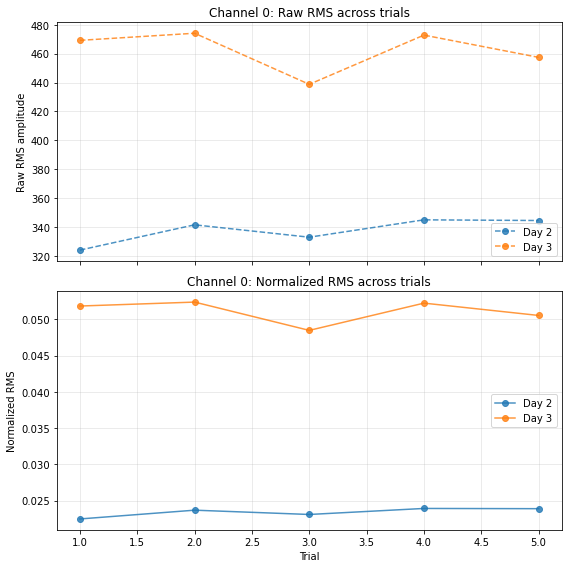

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# ---- RAW RMS ----
for day in days:
    sub = rms_df[rms_df["day"] == day].sort_values("trial")
    axes[0].plot(sub["trial"], sub["rms_raw"], "--o", alpha=0.8, label=f"Day {day}")

axes[0].set_ylabel("Raw RMS amplitude")
axes[0].set_title(f"Channel {ch_idx}: Raw RMS across trials")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ---- NORMALIZED RMS ----
for day in days:
    sub = rms_df[rms_df["day"] == day].sort_values("trial")
    axes[1].plot(sub["trial"], sub["rms_norm"], "-o", alpha=0.8, label=f"Day {day}")

axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Normalized RMS")
axes[1].set_title(f"Channel {ch_idx}: Normalized RMS across trials")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
